In [245]:
import numpy as np
import os
import random
import glob
import pandas as pd
import time
import sklearn as sk
import matplotlib.pyplot as plt
import importlib
from common import common
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from concurrent.futures import ProcessPoolExecutor
from functools import partial

In [261]:
# Reload common module
importlib.reload(common)

<module 'common.common' from '/Users/suyeetan/Downloads/CS5344_Project/work/common/common.py'>

In [247]:
# Shared variables
OUTPUT_FOLDER = 'csv_files'
FEATURE_FOLDER = 'features'
TEST_COUNT = 15000

In [248]:
# %run datasets/covertype.ipynb
# %run datasets/kdd.ipynb
# %run datasets/cicids.ipynb
# %run datasets/unsw.ipynb
%run datasets/thyroid.ipynb

In [249]:
# Should already be one hot encoded and label encoded
# all_df, main_labels, config = get_processed_covtype_df()
# all_df, main_labels, config = get_processed_kdd_df()
# all_df, main_labels, config = get_processed_cicids_df()
# all_df, main_labels, config = get_processed_unsw_df()
all_df, main_labels, config = get_processed_thyroid_df()
TARGET_COLUMN = config['TARGET_COLUMN']
NORMAL_TARGET = config['NORMAL_TARGET']
TARGET_DICT = config['TARGET_DICT']
INV_TARGET_DICT = config['INV_TARGET_DICT']
NUMERICAL_COLUMNS = config['NUMERICAL_COLUMNS']
CATEGORICAL_COLUMNS = config['CATEGORICAL_COLUMNS']
ORDINAL_COLUMNS = config['ORDINAL_COLUMNS']
all_df.head()

Normal class:  0    -
Name: target, dtype: object


/var/folders/r2/_111ch9s3n3gs8f8291g9xj00000gn/T/ipykernel_86746/2572836340.py:39: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_df['pregnant'] = all_df['pregnant'].replace({'t': 1, 'f': 0})


Imputing row 1/6652 with 1 missing, elapsed time: 4.420
Imputing row 101/6652 with 0 missing, elapsed time: 4.427
Imputing row 201/6652 with 1 missing, elapsed time: 4.428
Imputing row 301/6652 with 1 missing, elapsed time: 4.429
Imputing row 401/6652 with 0 missing, elapsed time: 4.430
Imputing row 501/6652 with 0 missing, elapsed time: 4.430
Imputing row 601/6652 with 1 missing, elapsed time: 4.431
Imputing row 701/6652 with 0 missing, elapsed time: 4.432
Imputing row 801/6652 with 0 missing, elapsed time: 4.433
Imputing row 901/6652 with 1 missing, elapsed time: 4.433
Imputing row 1001/6652 with 0 missing, elapsed time: 4.434
Imputing row 1101/6652 with 0 missing, elapsed time: 4.435
Imputing row 1201/6652 with 1 missing, elapsed time: 4.435
Imputing row 1301/6652 with 0 missing, elapsed time: 4.436
Imputing row 1401/6652 with 0 missing, elapsed time: 4.436
Imputing row 1501/6652 with 0 missing, elapsed time: 4.437
Imputing row 1601/6652 with 0 missing, elapsed time: 4.437
Imputing 

,age,TT4,T3,T4U,FTI,TSH,pregnant,target
18,63,48.0,1.287035,1.02,47.0,68.00,0,1
19,36,90.0,2.400000,1.06,85.0,1.50,0,0
21,40,104.0,2.300000,1.08,96.0,1.20,0,0
22,40,88.0,2.100000,0.84,105.0,5.90,0,0
23,77,107.0,2.400000,1.13,95.0,0.05,0,0


In [250]:
all_df.shape

(6652, 8)

In [251]:
# Create a folder to save the CSVs
common.remove_files_from_directory(OUTPUT_FOLDER)
common.remove_files_from_directory(FEATURE_FOLDER)
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
os.makedirs(FEATURE_FOLDER, exist_ok=True)

All files in csv_files have been removed.
All files in features have been removed.


In [252]:
# Save all data as csv
all_df.to_csv('all_data.csv' ,index = False)

In [253]:
# Get X and y from all_df
X_df = all_df.drop(columns=[TARGET_COLUMN])
y_df = all_df[TARGET_COLUMN]

# Split the data into training and test sets
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_df, y_df, test_size=0.2, random_state=42)
print(X_train_df.shape, X_test_df.shape, y_train_df.shape, y_test_df.shape)

(5321, 7) (1331, 7) (5321,) (1331,)


In [254]:
# Concatenate X_train and y_train along the columns (axis=1)
X_y_train_df = pd.concat([X_train_df, y_train_df], axis=1)
X_y_train_df.head()

,age,TT4,T3,T4U,FTI,TSH,pregnant,target
5554,61,126.0,2.246201,1.36,93.0,6.900000,0,1
610,34,93.0,2.700000,1.10,85.0,2.500013,0,0
5384,46,48.0,1.200000,0.89,54.0,4.600000,0,1
7260,29,164.0,2.782777,1.10,149.0,0.680000,0,0
8360,49,80.0,1.721090,0.66,121.0,1.800000,0,0


In [255]:
# Fit and transform the numeric columns
scaler, X_train_scaled_df = common.standardise(X_train_df, NUMERICAL_COLUMNS)
# print('X_train_scaled_df', X_train_scaled_df)

# Use the same scaler to transform X_test
scaler, X_test_scaled_df = common.standardise(X_test_df, NUMERICAL_COLUMNS, scaler=scaler)
# print('X_test_scaled_df', X_test_scaled_df)

In [256]:
benign = 2359289
abnormal_type_counts = all_df[TARGET_COLUMN].value_counts()
abnormal_type_dict = abnormal_type_counts.to_dict()
print('abnormal_type_dict', abnormal_type_dict)
target_index = all_df.columns.get_loc(TARGET_COLUMN)
benign_ratio = 2  # Adjust this ratio as needed
min_benign_samples = 50  # Ensure at least 50 benign samples are always included

# Parallel execution to create the anomaly datasets for each anomaly class
with ProcessPoolExecutor() as executor:
    futures = []
    for label, name in TARGET_DICT.items():
        if label == NORMAL_TARGET:
            continue  # Skip the normal target
        
        # Submit tasks to the executor
        futures.append(executor.submit(common.create_dataset_for_label, label, name, benign, abnormal_type_dict, benign_ratio, min_benign_samples, all_df, target_index, TARGET_COLUMN, NORMAL_TARGET, OUTPUT_FOLDER, main_labels))
    
    # Retrieve results (optional, here we're just ensuring completion)
    for future in futures:
        name = future.result()  # Ensures all tasks are done
        print(f"Dataset for {name} processed.")

print("All datasets created successfully!")

abnormal_type_dict {0: 5819, 1: 616, 2: 217}
Dataset for Hypothyroid processed.
Dataset for Hyperthyroid processed.
Hyperthyroid.csv created with 651 rows. (434 benign and 217 abnormal rows)
Hypothyroid.csv created with 1848 rows. (1232 benign and 616 abnormal rows)
All datasets created successfully!


In [257]:
# tdf = pd.read_csv('csv_files/smurf.csv')
# tdf['attack'].unique()
# len(main_labels)
all_df.head()

,age,TT4,T3,T4U,FTI,TSH,pregnant,target
18,63,48.0,1.287035,1.02,47.0,68.00,0,1
19,36,90.0,2.400000,1.06,85.0,1.50,0,0
21,40,104.0,2.300000,1.08,96.0,1.20,0,0
22,40,88.0,2.100000,0.84,105.0,5.90,0,0
23,77,107.0,2.400000,1.13,95.0,0.05,0,0


In [258]:
seconds = time.time()

# CSV files names:
csv_files=os.listdir(OUTPUT_FOLDER)
print('csv_files',csv_files)

feature_importances = {}
SVMs = {}

for csv in csv_files:
    label, important_features, svm, impor_bars, voting_clf = process_csv_with_args(csv, 
        main_labels=main_labels, 
        target_column=TARGET_COLUMN, 
        normal_target=NORMAL_TARGET, 
        numerical_columns=NUMERICAL_COLUMNS, 
        output_folder=OUTPUT_FOLDER,
        scaler=scaler)
    feature_importances[label] = important_features
    SVMs[label] = svm

# process_csv_with_args = partial(
#         common.process_csv, 
#         main_labels=main_labels, 
#         target_column=TARGET_COLUMN, 
#         normal_target=NORMAL_TARGET, 
#         numerical_columns=NUMERICAL_COLUMNS, 
#         output_folder=OUTPUT_FOLDER,
#         scaler=scaler 
#     )

# # Parallel execution to get the most important features of each csv
# with ProcessPoolExecutor() as executor:
#         results = list(executor.map(process_csv_with_args, csv_files))

# Collect results from the futures
# for label, important_features, svm, impor_bars, voting_clf in results:
#     feature_importances[label] = important_features
#     SVMs[label] = svm

#     # Show feature importance
#     common.show_feature_importance(impor_bars, label, FEATURE_FOLDER)
#     print("-----------------------------------------------------------------------------------------------\n\n\n\n")

print('feature_importances:', feature_importances)
print("Total operation time: =", time.time() - seconds, "seconds")

csv_files ['Hypothyroid.csv', 'Hyperthyroid.csv']
Processing CSV file: Hypothyroid.csv
Processing CSV file: Hyperthyroid.csv
feature_importances: {'Hypothyroid': ['TSH', 'TT4', 'FTI', 'T4U', 'age'], 'Hyperthyroid': ['FTI', 'T3', 'TT4', 'TSH', 'age']}
Total operation time: = 0.514739990234375 seconds


In [259]:
seconds = time.time()

# Step 1: Train KNN to classify
knn = KNeighborsClassifier(n_neighbors=5)
# knn.fit(X_train_scaled_df, y_train_df)
knn.fit(X_train_df, y_train_df)

# Step 2: Predict classes for the test set
print('Cap testset with length ', len(X_test_df),' at ',TEST_COUNT)
X_test_df = X_test_df[:TEST_COUNT]
X_test_scaled_df = X_test_scaled_df[:TEST_COUNT]
y_test_df = y_test_df[:TEST_COUNT]

# knn_predictions = knn.predict(X_test_scaled)
knn_predictions = knn.predict(X_test_df)
print('knn_predictions', knn_predictions)

print("Total operation time: = ",time.time()- seconds ,"seconds")

Cap testset with length  1331  at  15000
knn_predictions [0 0 0 ... 0 0 0]
Total operation time: =  0.035176992416381836 seconds


-----KNN Evaluation-----


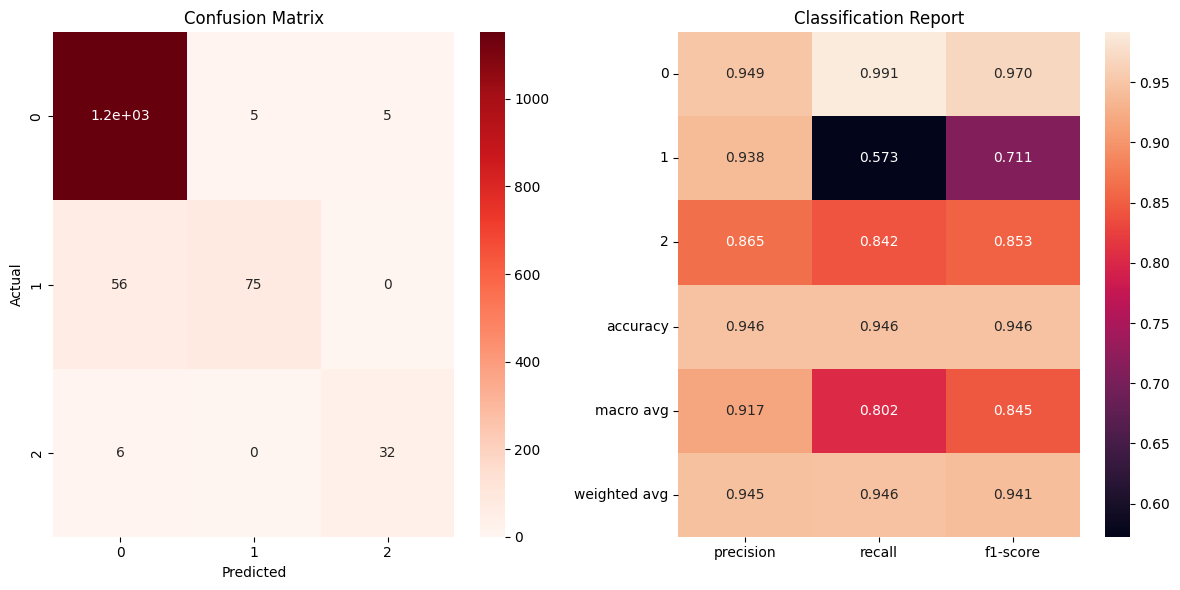

Accuracy: 0.9459053343350864


(array([[1152,    5,    5],
        [  56,   75,    0],
        [   6,    0,   32]]),
 {'0': {'precision': 0.9489291598023064,
   'recall': 0.9913941480206541,
   'f1-score': 0.9696969696969697,
   'support': 1162.0},
  '1': {'precision': 0.9375,
   'recall': 0.5725190839694656,
   'f1-score': 0.7109004739336493,
   'support': 131.0},
  '2': {'precision': 0.8648648648648649,
   'recall': 0.8421052631578947,
   'f1-score': 0.8533333333333334,
   'support': 38.0},
  'accuracy': 0.9459053343350864,
  'macro avg': {'precision': 0.9170980082223904,
   'recall': 0.8020061650493382,
   'f1-score': 0.8446435923213175,
   'support': 1331.0},
  'weighted avg': {'precision': 0.9454042438430841,
   'recall': 0.9459053343350864,
   'f1-score': 0.9409034617128877,
   'support': 1331.0}},
 0.9459053343350864)

In [262]:
common.evaluate(y_test_df, knn_predictions, heading='-----KNN Evaluation-----', target_dict=config['TARGET_DICT'])

In [263]:
svm_predictions = []
seconds = time.time()

for i in range(len(X_test_scaled_df)):
    test_instance_df = X_test_scaled_df.iloc[i].to_frame().T
    if knn_predictions[i] == NORMAL_TARGET:
        svm_predictions.append((0, NORMAL_TARGET, y_test_df.iloc[i]))
        continue
    predicted_label = TARGET_DICT[knn_predictions[i]]
    # print('predicted_label', predicted_label)
    selected_features = feature_importances[predicted_label]
    # print('selected_features', selected_features)
    svm_model = SVMs[predicted_label]
    
    # Select features for the SVM
    test_instance_selected_df = test_instance_df[selected_features]
    svm_prediction = svm_model.predict(test_instance_selected_df)
    print('svm prediction: ', svm_prediction, 'knn prediction: ', INV_TARGET_DICT[predicted_label], 'actual value: ', y_test_df.iloc[i])
    svm_predictions.append((svm_prediction, INV_TARGET_DICT[predicted_label], y_test_df.iloc[i]))

print("Total operation time: = ",time.time()- seconds ,"seconds")

svm prediction:  [0] knn prediction:  2 actual value:  2
svm prediction:  [0] knn prediction:  2 actual value:  2
svm prediction:  [0] knn prediction:  2 actual value:  2
svm prediction:  [0] knn prediction:  1 actual value:  1
svm prediction:  [0] knn prediction:  1 actual value:  1
svm prediction:  [0] knn prediction:  1 actual value:  0
svm prediction:  [0] knn prediction:  2 actual value:  2
svm prediction:  [0] knn prediction:  2 actual value:  2
svm prediction:  [0] knn prediction:  1 actual value:  1
svm prediction:  [0] knn prediction:  1 actual value:  1
svm prediction:  [0] knn prediction:  1 actual value:  1
svm prediction:  [0] knn prediction:  1 actual value:  1
svm prediction:  [0] knn prediction:  1 actual value:  1
svm prediction:  [0] knn prediction:  1 actual value:  1
svm prediction:  [0] knn prediction:  2 actual value:  2
svm prediction:  [0] knn prediction:  1 actual value:  0
svm prediction:  [0] knn prediction:  2 actual value:  2
svm prediction:  [0] knn predic

-----SVM Evaluation (for anomalies)-----


/Users/suyeetan/Downloads/CS5344_Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/suyeetan/Downloads/CS5344_Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/suyeetan/Downloads/CS5344_Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

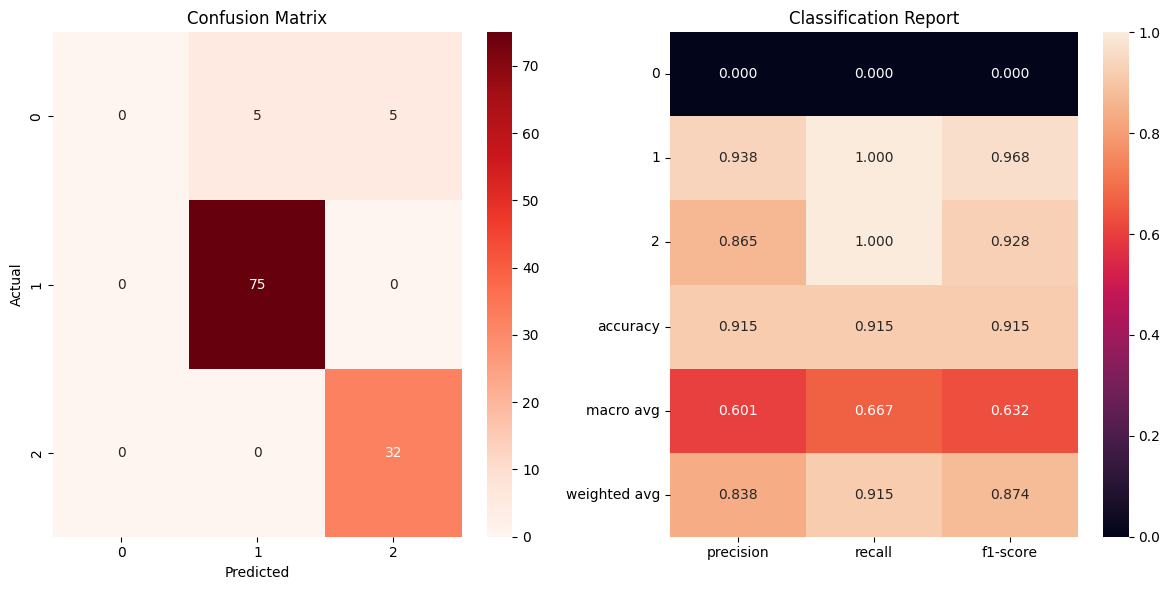

Accuracy: 0.9145299145299145


(array([[ 0,  5,  5],
        [ 0, 75,  0],
        [ 0,  0, 32]]),
 {'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 10.0},
  '1': {'precision': 0.9375,
   'recall': 1.0,
   'f1-score': 0.967741935483871,
   'support': 75.0},
  '2': {'precision': 0.8648648648648649,
   'recall': 1.0,
   'f1-score': 0.927536231884058,
   'support': 32.0},
  'accuracy': 0.9145299145299145,
  'macro avg': {'precision': 0.6007882882882883,
   'recall': 0.6666666666666666,
   'f1-score': 0.6317593891226431,
   'support': 117.0},
  'weighted avg': {'precision': 0.837505775005775,
   'recall': 0.9145299145299145,
   'f1-score': 0.8740325177912835,
   'support': 117.0}},
 0.9145299145299145)

In [264]:
# Now evaluate SVM predictions only for the anomalies detected by KNN
# Create a mask for test instances that KNN classified as anomalies
anomaly_mask = knn_predictions != NORMAL_TARGET  # Assuming normal_target is your normal class
# print('anomaly_mask', len(anomaly_mask))

# Get true labels and predictions for anomalies
svm_predictions_actual = [knn if pred == 0 else NORMAL_TARGET for pred, knn, y_test in svm_predictions]
# print(svm_predictions_actual)
svm_predictions_actual_df = pd.DataFrame(svm_predictions_actual, columns=[TARGET_COLUMN])
y_test_anomalies_df = y_test_df[anomaly_mask]
svm_predictions_anomalies_df = svm_predictions_actual_df[anomaly_mask]
# print('Lengths: ', len(y_test_anomalies_df), len(svm_predictions_anomalies_df))

# Evaluate SVM only on the anomalies
common.evaluate(y_test_anomalies_df, svm_predictions_anomalies_df, heading='-----SVM Evaluation (for anomalies)-----', target_dict=config['TARGET_DICT'])

SVM Evaluation (for all)


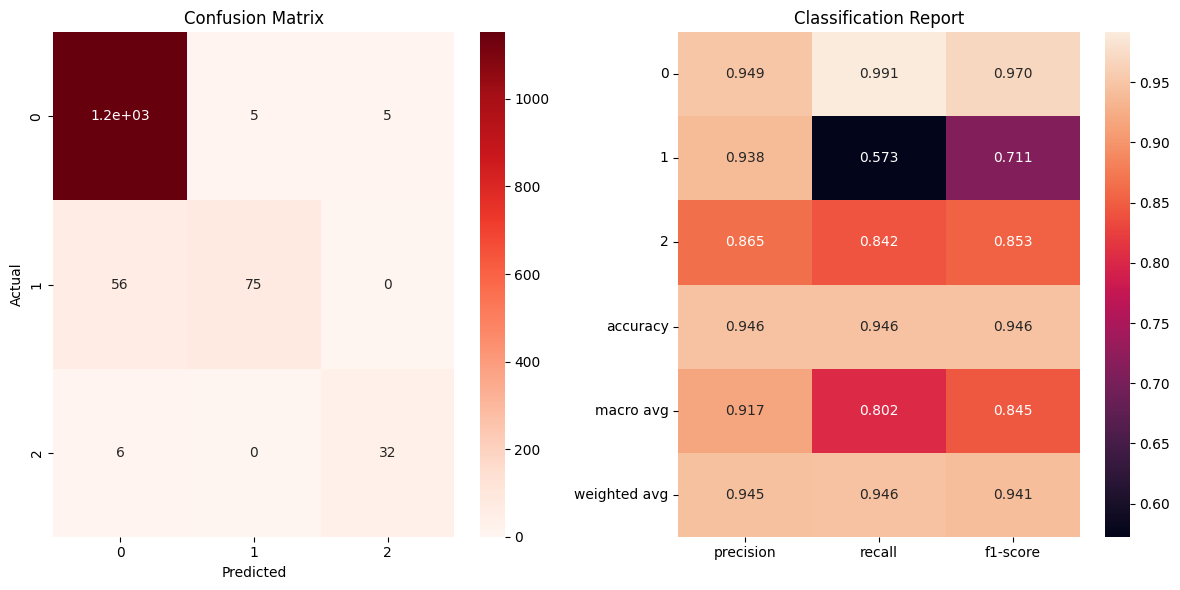

Accuracy: 0.9459053343350864


(array([[1152,    5,    5],
        [  56,   75,    0],
        [   6,    0,   32]]),
 {'0': {'precision': 0.9489291598023064,
   'recall': 0.9913941480206541,
   'f1-score': 0.9696969696969697,
   'support': 1162.0},
  '1': {'precision': 0.9375,
   'recall': 0.5725190839694656,
   'f1-score': 0.7109004739336493,
   'support': 131.0},
  '2': {'precision': 0.8648648648648649,
   'recall': 0.8421052631578947,
   'f1-score': 0.8533333333333334,
   'support': 38.0},
  'accuracy': 0.9459053343350864,
  'macro avg': {'precision': 0.9170980082223904,
   'recall': 0.8020061650493382,
   'f1-score': 0.8446435923213175,
   'support': 1331.0},
  'weighted avg': {'precision': 0.9454042438430841,
   'recall': 0.9459053343350864,
   'f1-score': 0.9409034617128877,
   'support': 1331.0}},
 0.9459053343350864)

In [265]:
common.evaluate(y_test_df, svm_predictions_actual_df, heading='SVM Evaluation (for all)', target_dict=config['TARGET_DICT'])